In [1]:
import sys
import os
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import vis_utils
import misc_utils
import metric_utils

In [2]:
from generate_data import generate_nglf_from_model
from generate_data import generate_general_make_spd
from metric_utils import calculate_nll_score

In [3]:
import theano_time_corex

Using cuDNN version 6021 on context None
Mapped name None to device cuda0: GeForce GTX 1080 Ti (0000:01:00.0)


# Try initializing T-Corex with W of Linear Corex learned on *whole* data

### Load some data

In [4]:
m = 8
bs = 16
nv = m * bs
train_cnt = 8
test_cnt = 100
nt = 5
(data, ground_truth) = generate_nglf_from_model(nv=nv, m=m, nt=nt, ns=train_cnt + test_cnt, snr=5.0)
train_data = [X[:train_cnt] for X in data]
test_data = [X[train_cnt:] for X in data]
ground_truth = [ground_truth] * nt

Fixed SNR: 5.0


In [52]:
grouth_truth_score = calculate_nll_score(data=test_data, covs=ground_truth)
print "Ground truth score = {}".format(grouth_truth_score)

Ground truth score = 189.625280736


In [6]:
whole_train_data = np.concatenate(train_data, axis=0)
print whole_train_data.shape

whole_test_data = np.concatenate(test_data, axis=0)
print whole_test_data.shape

(40, 128)
(500, 128)


### learn linear corex on whole data

In [7]:
import linearcorex
corex = linearcorex.Corex(n_hidden=m,
                         max_iter=500,
                         verbose=True,
                         anneal=True)
corex.fit(whole_train_data)

Linear CorEx with 8 latent factors
61 iterations to tol: 0.000010
8 iterations to tol: 0.000010
8 iterations to tol: 0.000010
6 iterations to tol: 0.000010
3 iterations to tol: 0.000010
5 iterations to tol: 0.000010
1 iterations to tol: 0.000010


In [53]:
linear_corex_whole_score = calculate_nll_score(data=[whole_test_data], covs=[corex.get_covariance()])
print "Linear Corex (on whole data) score = {}".format(linear_corex_whole_score)

Linear Corex (on whole data) score = 193.785823083


### learn theano linear corex on whole data

In [9]:
import theano_linear_corex

In [10]:
corex = theano_linear_corex.Corex(nv=nv,
                                  n_hidden=m,
                                  max_iter=500,
                                  verbose=True,
                                  anneal=True)

corex.fit(whole_train_data)

Linear CorEx with 8 latent factors
tc = 6.90082114047, obj = -17.350791412, eps = 0.6
tc = 11.3315959732, obj = -23.4944327431, eps = 0.6
tc = 14.6156455037, obj = -22.6404086902, eps = 0.6
tc = 17.2757312109, obj = -24.3352921934, eps = 0.6
tc = 19.7917018953, obj = -27.6302941605, eps = 0.6
tc = 22.2295389751, obj = -31.6037549989, eps = 0.6
tc = 24.2638909214, obj = -30.7204841707, eps = 0.6
tc = 25.8287537453, obj = -30.6756463564, eps = 0.6
tc = 27.0474509832, obj = -34.3507961619, eps = 0.6
tc = 28.0279640745, obj = -37.0237123505, eps = 0.6
tc = 28.80036028, obj = -37.5630538516, eps = 0.6
tc = 29.3850150157, obj = -38.3279792095, eps = 0.6
tc = 29.8162415134, obj = -37.93599108, eps = 0.6
tc = 30.3023346884, obj = -39.226052831, eps = 0.6
tc = 30.7129708056, obj = -37.5702231183, eps = 0.6
tc = 31.0060448601, obj = -38.2285170492, eps = 0.6
tc = 31.2827123706, obj = -39.0074749719, eps = 0.6
tc = 31.5586116851, obj = -39.3355209163, eps = 0.6
tc = 31.767999094, obj = -40.012813

tc = 100.373378316, obj = -101.178434214, eps = 0.07776
tc = 100.365995526, obj = -101.15033523, eps = 0.07776
tc = 100.360055514, obj = -100.655682428, eps = 0.07776
tc = 100.37322208, obj = -100.766877071, eps = 0.07776
tc = 100.373405337, obj = -101.262524398, eps = 0.07776
tc = 100.362747774, obj = -101.309670622, eps = 0.07776
tc = 100.362451479, obj = -100.63842121, eps = 0.07776
tc = 100.355945275, obj = -101.108350399, eps = 0.07776
tc = 100.345860474, obj = -100.294099713, eps = 0.07776
tc = 100.367388702, obj = -100.199414527, eps = 0.07776
tc = 100.378810998, obj = -100.6574866, eps = 0.07776
tc = 100.378415502, obj = -101.059604413, eps = 0.07776
tc = 100.381501884, obj = -100.464471557, eps = 0.07776
tc = 100.378251906, obj = -101.227703016, eps = 0.07776
tc = 101.600625652, obj = -102.408653724, eps = 0.046656
tc = 101.563482199, obj = -102.438604923, eps = 0.046656
tc = 101.593066746, obj = -102.028478581, eps = 0.046656
tc = 101.589791021, obj = -102.013631874, eps = 0.

<theano_linear_corex.Corex instance at 0x7f15c076c878>

In [54]:
theano_linaer_corex_whole_score = calculate_nll_score(data=[whole_test_data], covs=[corex.get_covariance()])
print "Theano Linear Corex (on whole data) score = {}".format(theano_linaer_corex_whole_score)

Theano Linear Corex (on whole data) score = 193.785823083


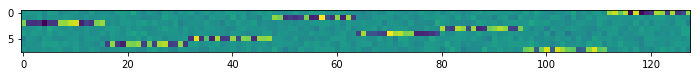

In [12]:
lc_W = corex.ws.get_value()
plt.figure(figsize=(12, 6))
plt.imshow(lc_W)

### learn T-Corex without pretraining

In [ ]:
best_nll = np.inf
best_tcorex = None
best_l1 = None
coefs = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1.0, 3.0, 10.0, 100.0, 1000.0, 1e4, 1e5, 1e6]
t_corex_nlls = []
for l1 in coefs:
    print "training with l1 = {}".format(l1)
    tcorex = theano_time_corex.TimeCorexW(nt=nt,
                                        nv=nv,
                                        n_hidden=m,
                                        max_iter=500,
                                        verbose=False,
                                        anneal=True,
                                        l1=l1)
    tcorex.fit(train_data)
    tcorex_covs = tcorex.get_covariance()
    nll = metric_utils.calculate_nll_score(data=test_data, covs=tcorex_covs)
    t_corex_nlls.append(nll)
    print "l1 = {}, nll = {}".format(l1, nll)
    if np.mean(nll) < best_nll:
        best_nll = np.mean(nll)
        best_tcorex = tcorex
        best_l1 = l1

print "best l1 = {}".format(best_l1)
tcorex = best_tcorex
print sum(tcorex.tc)

training with l1 = 0.001
Annealing iteration finished, time = 1.59683895111
Annealing iteration finished, time = 1.6021771431
Annealing iteration finished, time = 1.59802007675
Annealing iteration finished, time = 1.60327100754
Annealing iteration finished, time = 1.59344506264
Annealing iteration finished, time = 1.59963703156
Annealing iteration finished, time = 1.59673500061
l1 = 0.001, nll = 230.427548919
training with l1 = 0.003
Annealing iteration finished, time = 1.55974006653
Annealing iteration finished, time = 1.56240105629
Annealing iteration finished, time = 1.56047105789
Annealing iteration finished, time = 1.55650901794
Annealing iteration finished, time = 1.56380605698
Annealing iteration finished, time = 1.56029701233
Annealing iteration finished, time = 1.56637406349
l1 = 0.003, nll = 233.721294568
training with l1 = 0.01


In [ ]:
t_corex_score = best_nll
print "T-Corex score = {}".format(t_corex_score)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(t_corex_nlls)
plt.xticks(range(nt), coefs);

In [ ]:
W = [x.get_value() for x in tcorex.ws]

In [ ]:
print "W_norm = {}".format(np.mean([np.abs(w).mean() for w in W]))

In [ ]:
for w in W:
    plt.figure(figsize=(12, 6))
    plt.imshow(w)

In [ ]:
print "reg term = {}".format(np.mean([np.mean(np.abs(W[t+1]-W[t])) for t in range(nt-1)]))

### learn T-Corex with pretraining

In [25]:
best_nll = np.inf
best_tcorex_pre = None
best_l1 = None
coefs = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1.0, 3.0, 10.0, 100.0, 1000.0, 1e4, 1e5, 1e6]
nlls = []
for l1 in coefs:
    print "training with l1 = {}".format(l1)
    tcorex_pre = theano_time_corex.TimeCorexW(nt=nt,
                                            nv=nv,
                                            n_hidden=m,
                                            max_iter=500,
                                            verbose=False,
                                            anneal=True,
                                            l1=l1,
                                            pretrained_weights=[lc_W]*nt)
    tcorex_pre.fit(train_data)
    tcorex_pre_covs = tcorex_pre.get_covariance()
    nll = metric_utils.calculate_nll_score(data=test_data, covs=tcorex_pre_covs)
    nlls.append(nll)
    print "l1 = {}, nll = {}".format(l1, nll)
    if np.mean(nll) < best_nll:
        best_nll = np.mean(nll)
        best_tcorex_pre = tcorex_pre
        best_l1 = l1

print "best l1 = {}".format(best_l1)
tcorex_pre = best_tcorex_pre
print sum(tcorex_pre.tc)

training with l1 = 0.001
Annealing iteration finished, time = 1.58506298065
Annealing iteration finished, time = 1.58525204659
Annealing iteration finished, time = 1.58054804802
Annealing iteration finished, time = 1.58487391472
Annealing iteration finished, time = 1.5843629837
Annealing iteration finished, time = 1.58387303352
Annealing iteration finished, time = 1.57994008064
l1 = 0.001, nll = 232.19554455
training with l1 = 0.003
Annealing iteration finished, time = 1.54131698608
Annealing iteration finished, time = 1.53729891777
Annealing iteration finished, time = 1.54226994514
Annealing iteration finished, time = 1.54475092888
Annealing iteration finished, time = 1.54522395134
Annealing iteration finished, time = 1.53809404373
Annealing iteration finished, time = 1.54076004028
l1 = 0.003, nll = 231.916747945
training with l1 = 0.01
Annealing iteration finished, time = 1.57459878922
Annealing iteration finished, time = 1.57154202461
Annealing iteration finished, time = 1.574237108

In [60]:
t_corex_pre_score = best_nll
print "T-Corex pretrained weights score = {}".format(t_corex_pre_score)

T-Corex pretrained weights score = 219.842122384


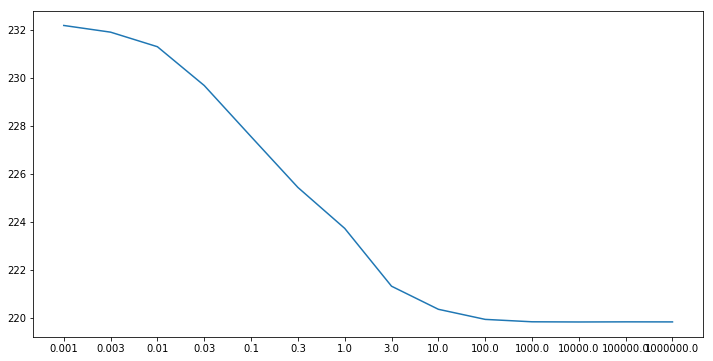

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(nlls)
plt.xticks(range(len(coefs)), coefs);

In [27]:
W = [x.get_value() for x in csig.ws]

In [28]:
print "W_norm = {}".format(np.mean([np.abs(w).mean() for w in W]))

W_norm = 0.0765035870891


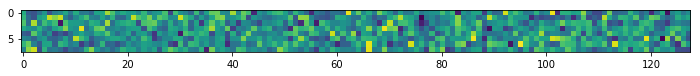

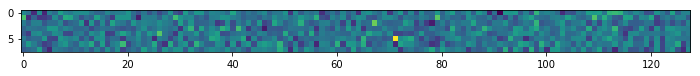

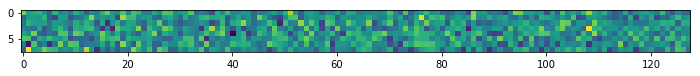

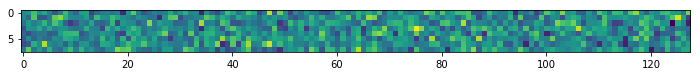

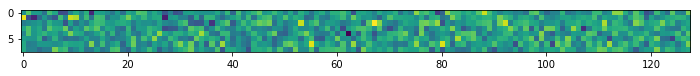

In [29]:
for w in W:
    plt.figure(figsize=(12, 6))
    plt.imshow(w)

In [30]:
print "reg term = {}".format(np.mean([np.mean(np.abs(W[t+1]-W[t])) for t in range(nt-1)]))

reg term = 0.107850580458


### pretrianed weights no training

In [32]:
no_training = theano_time_corex.TimeCorexW(nt=nt,
                                            nv=nv,
                                            n_hidden=m,
                                            max_iter=500,
                                            verbose=False,
                                            anneal=True,
                                            pretrained_weights=[lc_W]*nt)

In [34]:
no_training.fit(train_data)

Annealing iteration finished, time = 1.46535491943
Annealing iteration finished, time = 1.46516609192
Annealing iteration finished, time = 1.46339297295
Annealing iteration finished, time = 1.46209406853
Annealing iteration finished, time = 1.46563076973
Annealing iteration finished, time = 1.4645280838
Annealing iteration finished, time = 1.45729613304


In [38]:
for x, w in zip(no_training.ws, [lc_W]*nt):
    x.set_value(w)
no_training._update_u(no_training.x_std)
no_training._calculate_moments(no_training.x_std, no_training.ws);

In [39]:
W = [x.get_value() for x in no_training.ws]

In [40]:
print "W_norm = {}".format(np.mean([np.abs(w).mean() for w in W]))

W_norm = 0.108603874825


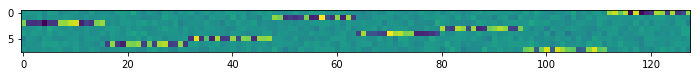

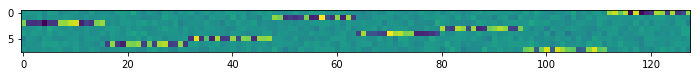

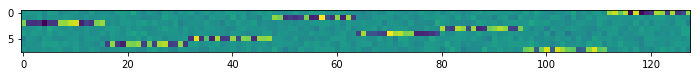

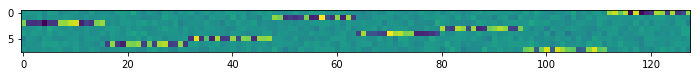

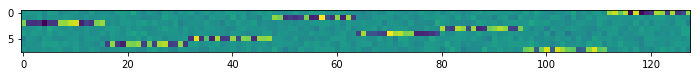

In [41]:
for w in W:
    plt.figure(figsize=(12, 6))
    plt.imshow(w)

In [42]:
print "reg term = {}".format(np.mean([np.mean(np.abs(W[t+1]-W[t])) for t in range(nt-1)]))

reg term = 0.0


In [43]:
no_training_covs = no_training.get_covariance()

In [61]:
t_corex_no_training_pretrained_score = calculate_nll_score(data=test_data, covs=no_training_covs)
print "T-Corex no training score, pretrained weights = {}".format(t_corex_no_training_pretrained_score)

T-Corex no training score, pretrained weights = 232.463848311


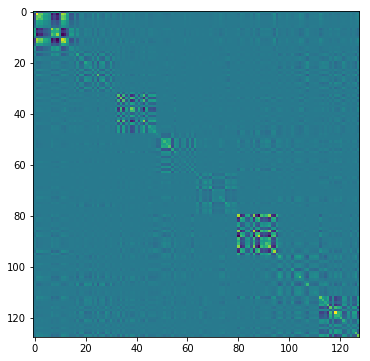

In [47]:
plt.figure(figsize=(6,6))
plt.imshow(no_training_covs[0])

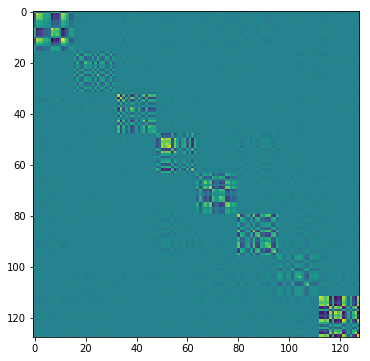

In [49]:
plt.figure(figsize=(6,6))
plt.imshow(corex.get_covariance())

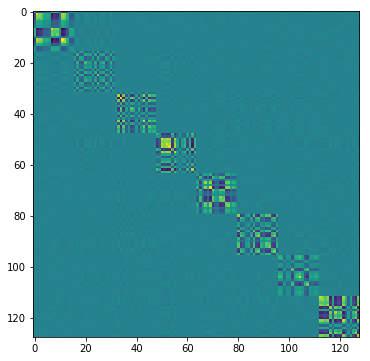

In [50]:
plt.figure(figsize=(6,6))
plt.imshow(np.cov(whole_test_data.T))

## summary

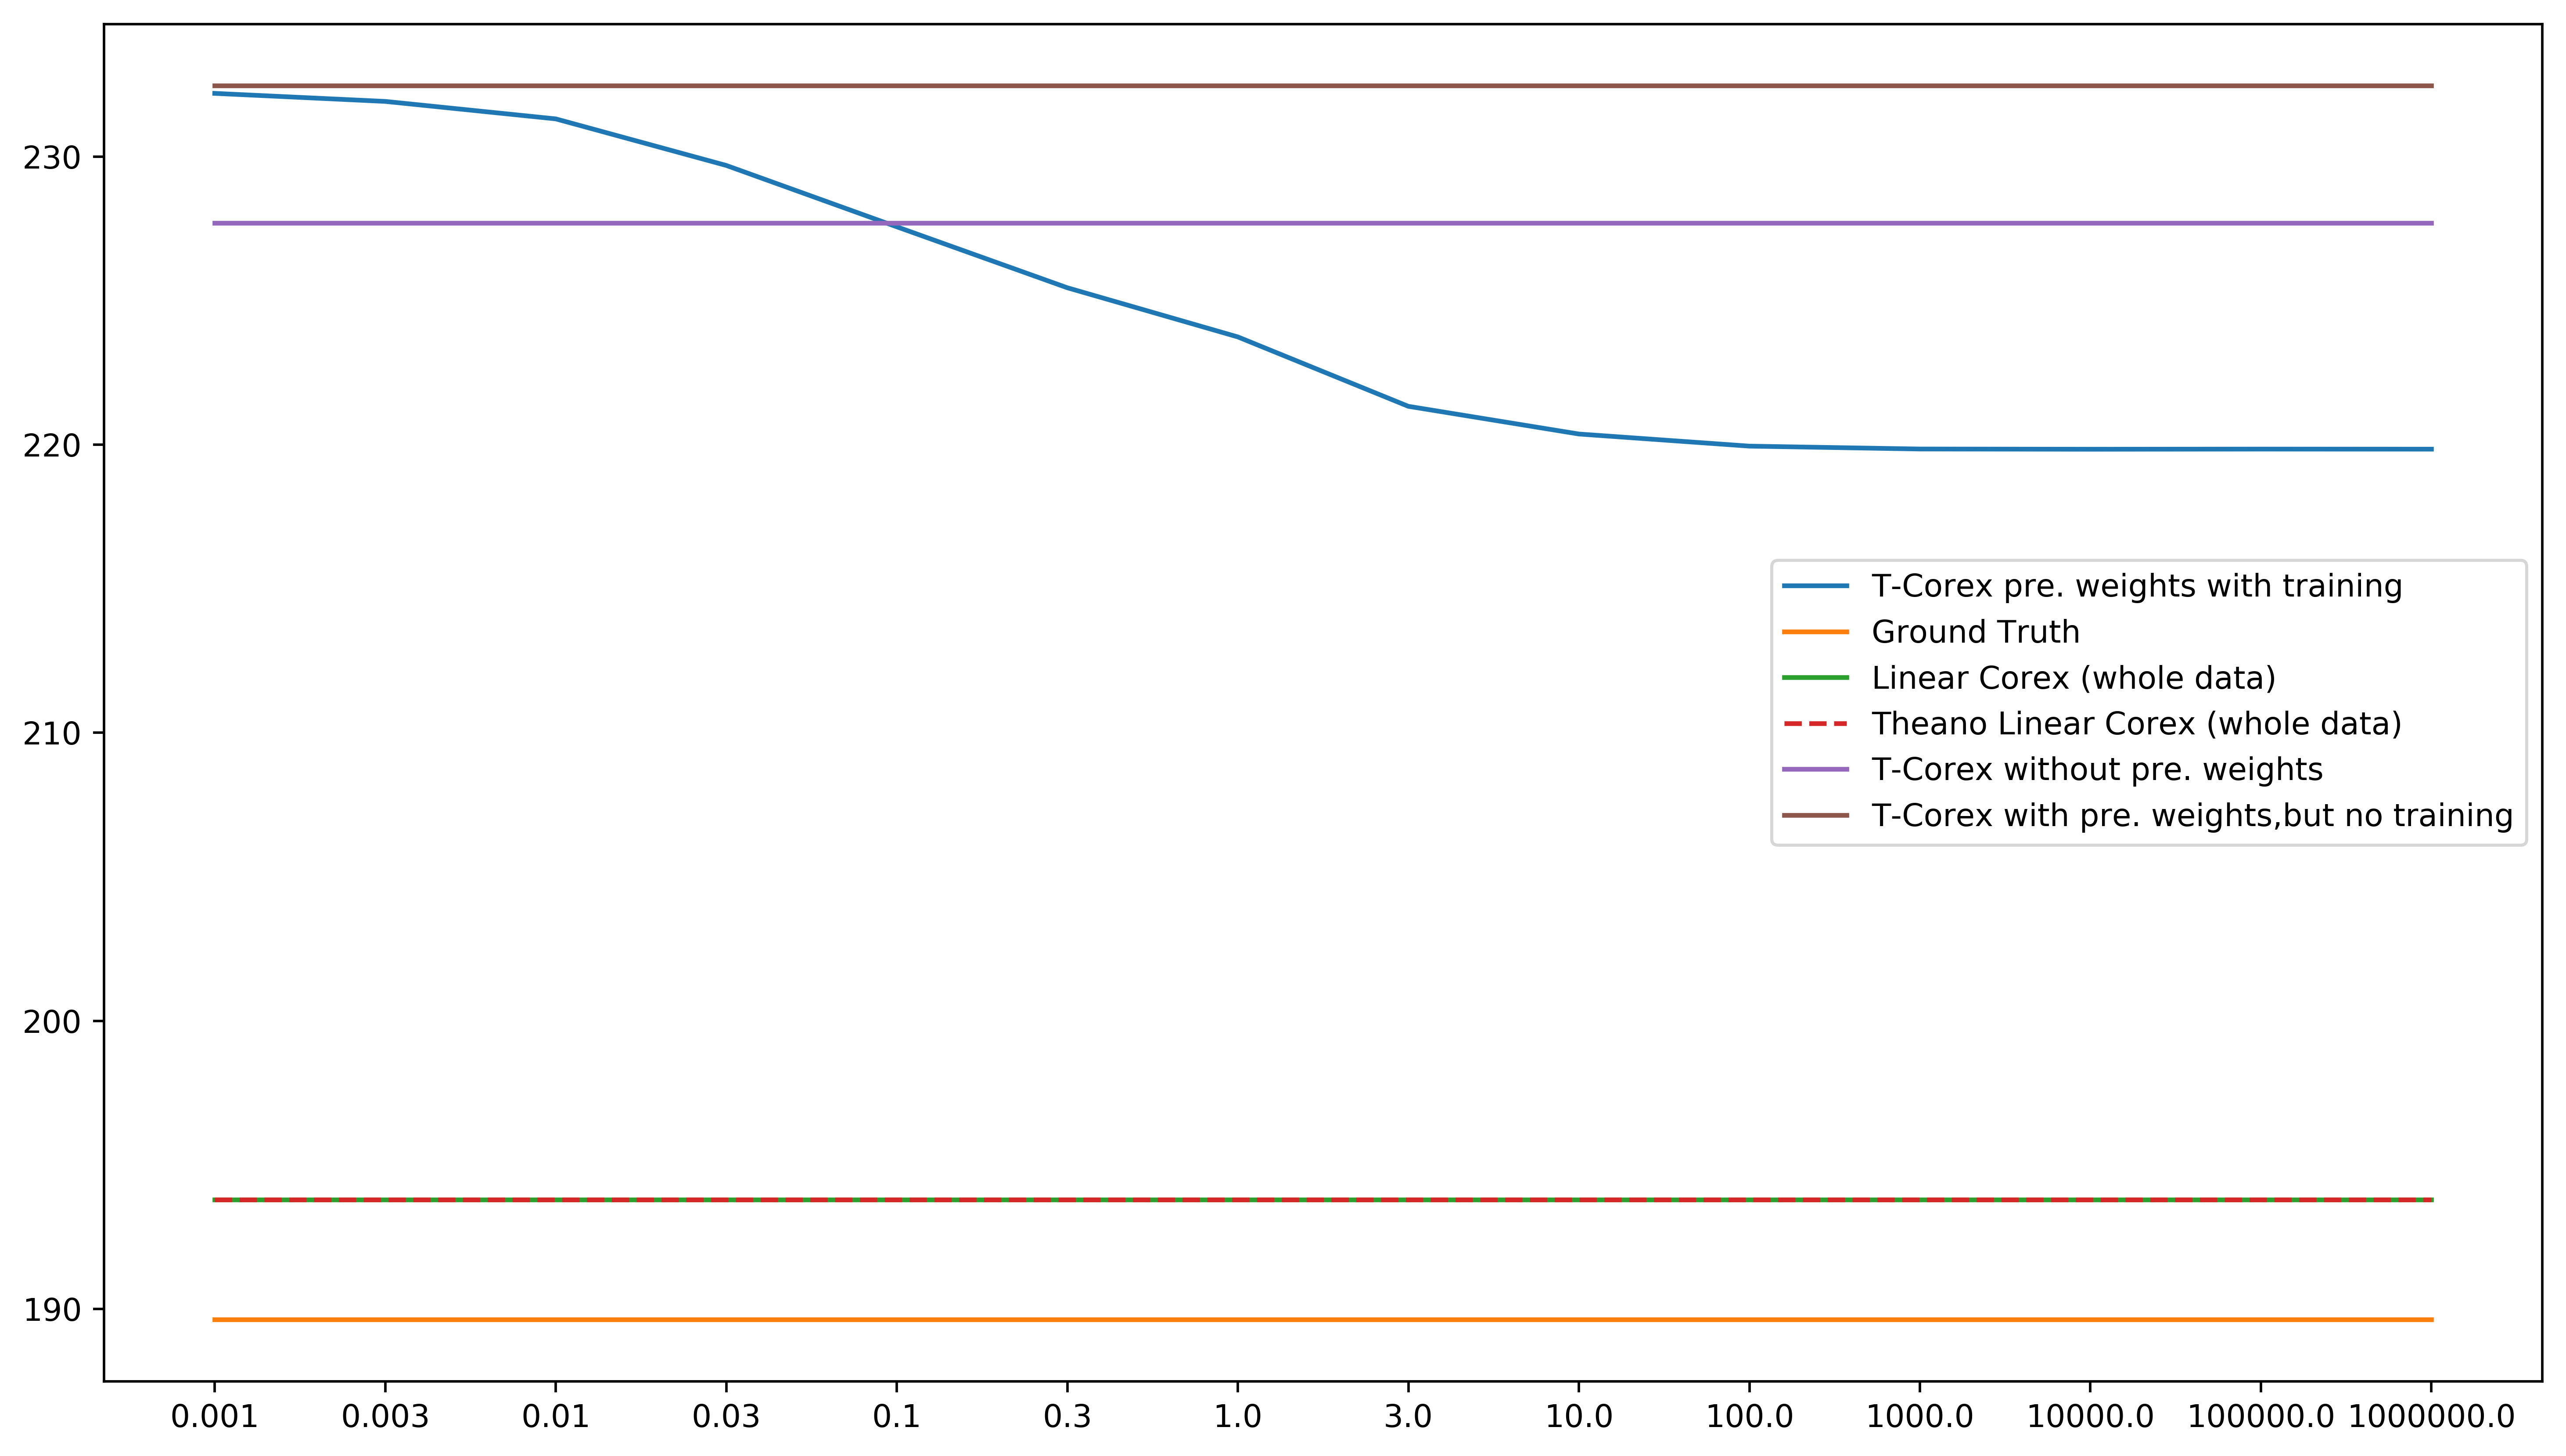

In [82]:
plt.figure(figsize=(14, 8), dpi=512)
plt.plot(nlls)
plt.xticks(range(len(coefs)), coefs);
plt.plot([0, len(coefs)-1], [grouth_truth_score, grouth_truth_score])
plt.plot([0, len(coefs)-1], [linear_corex_whole_score, linear_corex_whole_score], linestyle='-')
plt.plot([0, len(coefs)-1], [theano_linaer_corex_whole_score, theano_linaer_corex_whole_score], linestyle='--')
plt.plot([0, len(coefs)-1], [t_corex_score, t_corex_score])
plt.plot([0, len(coefs)-1], [t_corex_no_training_pretrained_score, t_corex_no_training_pretrained_score])
plt.legend(['T-Corex pre. weights with training',
           'Ground Truth',
           'Linear Corex (whole data)',
           'Theano Linear Corex (whole data)',
           'T-Corex without pre. weights',
           'T-Corex with pre. weights,but no training'])
plt.show()